**Final ROC_AUC SCORE (Public score) = 0.841**

* Basic EDA
* RandomForestClassifer
* LogisticRegression (+lasso)
* Feature selection - RFE, PCA

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
import warnings
warnings.filterwarnings("ignore")

['test.csv', 'train.csv', 'sample_submission.csv']


Load the data into training set & test set

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
samplesub_df = pd.read_csv('../input/sample_submission.csv')

**BASIC EDA**

In [3]:
train_df.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,...,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,...,0.971,-1.489,0.530,0.917,-0.094,-1.407,0.887,-0.104,-0.583,1.267,-1.667,-2.771,-0.516,1.312,0.491,0.932,2.064,0.422,1.215,2.012,0.043,-0.307,-0.059,1.121,1.333,0.211,1.753,0.053,1.274,-0.612,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,0.459,0.478,-0.425,0.352,1.095,0.300,-1.044,0.270,-1.038,0.144,-1.658,-0.946,0.633,-0.772,1.786,0.136,-0.103,-1.223,2.273,0.055,-2.032,-0.452,0.064,0.924,-0.692,-0.067,-0.917,1.896,...,-0.540,-0.299,1.074,-0.748,1.086,-0.766,-0.931,0.432,1.345,-0.491,-1.602,-0.727,0.346,0.780,-0.527,-1.122,-0.208,-0.730,-0.302,2.535,-1.045,0.037,0.020,1.373,0.456,-0.277,1.381,1.843,0.749,0.202,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,0.335,-1.148,0.067,-1.010,1.048,-1.442,0.210,0.836,-0.326,0.716,-0.764,0.248,-1.308,2.127,0.365,0.296,-0.808,1.854,0.118,0.380,0.999,-1.171,2.798,0.394,-1.048,1.078,0.401,-0.486,...,-0.083,-0.831,1.251,-0.206,-0.933,-1.215,0.281,0.512,-0.424,0.769,0.223,-0.710,2.725,0.176,0.845,-1.226,1.527,-1.701,0.597,0.150,1.864,0.322,-0.214,1.282,0.408,-0.910,1.020,-0.299,-1.574,-1.618,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,0.190,0.453,0.494,1.478,-1.412,0.270,-1.312,-0.322,-0.688,-0.198,-0.285,1.042,-0.315,-0.478,0.024,-0.190,1.656,-0.469,-1.437,-0.581,-0.308,-0.837,-1.739,0.037,0.336,-1.102,2.371,0.554,...,-1.050,-0.347,0.904,-1.324,-0.849,3.432,0.222,0.416,0.174,-1.517,-0.337,0.055,-0.464,0.014,-1.073,0.325,-0.523,-0.692,0.190,-0.883,-1.830,1.408,2.319,1.704,-0.723,1.014,0.064,0.096,-0.775,1.845,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [4]:
test_df.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,1.291,0.507,-0.317,1.848,-0.232,-0.340,-0.051,0.804,0.764,1.860,0.262,1.112,-0.491,-1.039,-0.492,0.183,-0.671,-1.313,0.149,0.244,1.072,-1.003,0.832,-1.075,1.988,1.201,-2.065,-0.826,-0.016,0.490,...,0.824,0.928,1.372,1.505,0.645,0.641,-1.132,1.009,0.998,0.210,-1.634,1.046,0.114,-0.806,0.301,0.145,-0.684,0.794,-0.290,-1.688,0.313,1.140,0.447,-0.616,1.294,0.785,0.453,1.550,-0.866,1.007,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,1.356,-1.086,0.322,0.876,-0.563,-1.394,0.385,1.891,-2.107,-0.636,-0.055,-0.843,0.041,0.253,0.557,0.475,-0.839,-1.146,1.210,1.427,0.347,1.077,-0.194,0.323,0.543,0.894,1.190,0.342,-0.858,0.756,...,-1.791,0.122,-0.669,-1.558,-0.244,2.583,-0.829,0.133,-2.746,0.341,-1.145,0.492,0.437,-0.628,0.271,2.639,0.481,-0.687,1.017,1.648,-1.272,-0.797,-0.870,-1.582,-1.987,-0.052,-0.194,0.539,-1.788,-0.433,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,0.167,-0.132,0.459,-0.341,0.014,0.184,-0.460,-0.991,-1.039,0.992,1.036,1.552,-0.830,1.374,-0.914,0.427,0.027,0.327,1.117,0.871,-2.556,-0.036,-0.081,0.744,-1.191,-1.784,0.239,0.500,0.437,0.746,...,-1.167,1.009,-0.180,-0.683,-1.383,1.020,0.268,-1.558,0.620,-0.489,-2.090,-0.977,1.672,-0.655,-0.801,-1.846,0.761,-0.846,0.181,0.962,-0.611,1.450,0.021,0.320,-0.951,-2.662,0.761,-0.665,-0.619,-0.645,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,0.567,0.356,-0.060,0.767,-0.196,0.359,0.080,-0.956,0.857,-0.655,-0.090,-0.008,-0.596,-0.413,-1.030,0.173,-0.969,0.998,0.079,0.790,-0.776,-0.374,-1.995,0.572,0.542,0.547,0.307,-0.074,1.703,-0.003,...,-1.029,-0.340,0.052,2.122,-0.136,-1.799,1.450,1.866,-0.273,-0.237,-0.207,-0.196,-1.106,-1.560,-0.934,2.167,0.323,0.583,1.480,-0.685,-0.473,-1.066,-0.271,0.506,-0.753,1.048,-0.450,-0.300,-1.221,0.235,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,-0.930,-0.098,0.896,0.293,-0.259,0.030,-0.661,0.921,0.006,-0.631,1.284,-1.167,-0.744,-2.184,2.146,1.130,0.017,1.421,-0.590,1.938,-0.194,0.794,0.579,0.521,0.635,-0.023,-0.892,-0.363,-0.360,0.405,...,-0.486,-0.068,-0.534,-1.322,0.500,0.263,-0.745,0.578,-0.064,0.738,-0.280,0.745,-0.588,-0.429,-0.588,0.154,-1.187,1.681,-0.832,-0.437,-0.038,-1.096,-0.156,3.565,-0.428,-0.384,1.243,-0.966,1.525,0.458,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


In [5]:
samplesub_df.head()

,id,target
0,250,0
1,251,0
2,252,0
3,253,0
4,254,0


In [6]:
print(train_df.shape, test_df.shape,samplesub_df.shape)

(250, 302) (19750, 301) (19750, 2)


training set has more features than observations. It is a small dataset which leads to overfitting easily for many algorithms with default hyperparameters

In [7]:
print(train_df['target'].unique())

[1. 0.]


Just two classes we need to predict. either 1 or 0

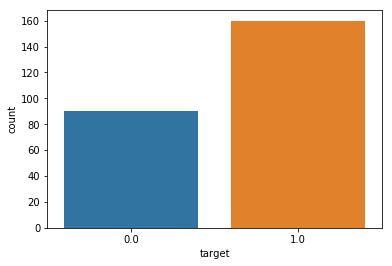

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(train_df['target'])

Visualizing how balanced the training set is,

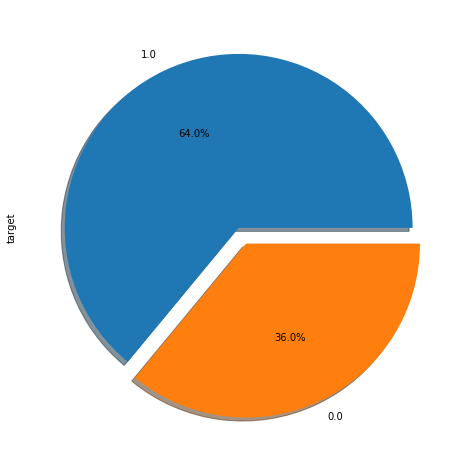

In [9]:
plt.figure(figsize=[8,8])
train_df['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True)
plt.show()

Just the mathematical way of above graph,

In [10]:
print(train_df['target'].value_counts())
Total = np.add(train_df['target'].where(train_df['target']==1).value_counts(), 
               train_df['target'].where(train_df['target']==0).value_counts())
print('target 1 : ',(train_df['target'].where(train_df['target']==1).value_counts()/Total)*100)
print('target 0 : ',100 - (train_df['target'].where(train_df['target']==1).value_counts()/Total)*100)

1.0    160
0.0     90
Name: target, dtype: int64
target 1 :  1.0    64.0
Name: target, dtype: float64
target 0 :  1.0    36.0
Name: target, dtype: float64


In [22]:
print(train_df.isnull().any().sum())
print(test_df.isnull().any().sum())

0
0


Luckily we don't have any missing values in both training set & test set.
nothing to do more here..

In [12]:
train_df.describe()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,124.500000,0.640000,0.023292,-0.026872,0.167404,0.001904,0.001588,-0.007304,0.032052,0.078412,-0.036920,0.035448,-0.005032,0.110248,0.019808,-0.001108,-0.016280,-0.039644,0.017260,-0.106856,0.036184,-0.043296,-0.110832,0.072680,0.017296,-0.030728,-0.128252,0.154736,0.083408,0.039552,-0.091784,0.054636,-0.048288,-0.017296,0.007708,-0.134460,0.093852,-0.020588,-0.002492,-0.141400,...,0.005780,-0.102304,-0.013796,0.089384,0.036368,0.016276,-0.069448,-0.113236,0.035696,0.034484,-0.066236,-0.057988,0.091556,-0.029896,0.115648,0.007372,0.033552,0.090524,0.001576,-0.007784,0.043184,0.082696,0.098476,0.055356,0.111708,-0.015688,0.035992,0.026452,-0.059152,0.077272,0.044652,0.126344,0.018436,-0.012092,-0.065720,-0.106112,0.046472,0.006452,0.009372,-0.128952
std,72.312977,0.480963,0.998354,1.009314,1.021709,1.011751,1.035411,0.955700,1.006657,0.939731,0.963688,1.019689,1.085089,1.036265,1.050041,1.024305,0.926789,0.955915,1.025655,1.012777,0.945099,1.055935,1.003178,1.039556,0.988482,0.945902,0.997026,0.997894,1.040371,0.922270,1.047282,1.041432,1.010971,0.992464,0.986350,1.015563,1.117898,0.958191,0.948855,1.042429,...,0.994761,1.094494,1.026025,0.963489,1.026373,1.008207,0.989451,1.002857,0.944743,1.023709,0.985451,0.951879,1.027877,0.966882,1.037173,1.004543,1.006219,1.037119,1.024067,1.056086,1.012516,1.068741,0.934163,0.988100,1.043230,1.010720,1.058982,0.896318,1.113760,0.972530,1.011416,0.972567,0.954229,0.960630,1.057414,1.038389,0.967661,0.998984,1.008099,0.971219
min,0.000000,0.000000,-2.319000,-2.931000,-2.477000,-2.359000,-2.566000,-2.845000,-2.976000,-3.444000,-2.768000,-2.361000,-3.302000,-2.851000,-2.681000,-2.596000,-3.275000,-3.512000,-2.476000,-3.619000,-2.428000,-3.229000,-3.024000,-2.775000,-2.962000,-2.490000,-3.107000,-2.943000,-2.933000,-2.942000,-2.957000,-2.911000,-2.568000,-2.649000,-3.031000,-2.913000,-3.265000,-2.372000,-3.037000,-3.340000,...,-2.512000,-2.873000,-2.549000,-2.721000,-2.578000,-2.239000,-3.046000,-2.755000,-2.507000,-3.369000,-2.448000,-2.771000,-2.903000,-2.522000,-2.759000,-2.915000,-2.618000,-3.623000,-2.673000,-3.229000,-2.537000,-2.748000,-2.850000,-2.577000,-2.973000,-2.709000,-3.605000,-2.357000,-2.904000,-2.734000,-2.804000,-2.443000,-2.757000,-2.466000,-3.287000,-3.072000,-2.634000,-2.776000,-3.211000,-3.500000
25%,62.250000,0.000000,-0.644750,-0.739750,-0.425250,-0.686500,-0.659000,-0.643750,-0.675000,-0.550750,-0.689500,-0.643500,-0.693500,-0.524000,-0.708500,-0.692000,-0.677000,-0.634500,-0.683500,-0.801500,-0.574250,-0.758000,-0.870500,-0.596000,-0.725750,-0.652000,-0.779500,-0.424250,-0.585750,-0.625000,-0.751250,-0.582500,-0.713500,-0.750000,-0.588000,-0.829000,-0.648500,-0.659750,-0.614000,-0.816750,...,-0.622750,-1.009250,-0.693250,-0.567750,-0.696500,-0.684000,-0.703750,-0.771250,-0.624500,-0.653000,-0.786750,-0.701000,-0.54

we dont need 'Id' column as it is unnecessary for model training,

In [13]:
cols = ['target','id']
X = train_df.drop(cols,axis=1)
y = train_df['target']
X_test = test_df.drop('id',axis=1)

In [25]:
from sklearn.model_selection import cross_val_score

#defining a generic Function to give ROC_AUC Scores in table format for better readability
def crossvalscore(model):
    scores = cross_val_score(model,X,y,cv=5,scoring='roc_auc',n_jobs=-1)
    acc = cross_val_score(model,X,y,cv=5,scoring='accuracy',n_jobs=-1)
    rand_scores = pd.DataFrame({
    'cv':range(1,6),
    'roc_auc score':scores,
    'accuracy score':acc
    })
    print('AUC :',rand_scores['roc_auc score'].mean())
    print('accuracy :',rand_scores['accuracy score'].mean())
    return rand_scores.sort_values(by='roc_auc score',ascending=False)

**1. RandomForest Classifier**

In [26]:
from sklearn.ensemble import RandomForestClassifier
rand_clf = RandomForestClassifier(max_depth=2,random_state=42)
crossvalscore(rand_clf)

AUC : 0.6305555555555555
accuracy : 0.64


,cv,roc_auc score,accuracy score
1,2,0.720486,0.70
0,1,0.635417,0.66
4,5,0.623264,0.64
2,3,0.612847,0.60
3,4,0.560764,0.60


* RandomForest Classifier has just avg 0.63 roc_auc score with an accuracy of 64%.
let's try some other algorithm

**LogisticRegression using PCA data**

In [29]:
#logistic regression using PCA
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
pca = PCA(n_components=42)
X_new = pca.fit_transform(X)

log_clf = LogisticRegression(C = 0.1, class_weight= 'balanced', penalty= 'l1', solver= 'liblinear',random_state=42)
scores = cross_val_score(log_clf,X_new,y,cv=5,scoring='roc_auc',n_jobs=-1)
acc = cross_val_score(log_clf,X_new,y,cv=5,scoring='accuracy',n_jobs=-1)
rand_scores = pd.DataFrame({
'cv':range(1,6),
'roc_auc score':scores,
'accuracy score':acc
})
print('AUC :',rand_scores['roc_auc score'].mean())
print('accuracy :',rand_scores['accuracy score'].mean())
rand_scores.sort_values(by='roc_auc score',ascending=False)

AUC : 0.7447916666666666
accuracy : 0.6519999999999999


,cv,roc_auc score,accuracy score
4,5,0.805556,0.72
3,4,0.765625,0.64
2,3,0.744792,0.62
0,1,0.730903,0.70
1,2,0.677083,0.58


avg roc_auc score is now 0.74 with 65% accuracy.

This is better than RandomForestClassifier scores

**2. Logistic Regression with Regularization**

In [30]:
from sklearn.linear_model import LogisticRegression
#simple logistic regression with lasso regularization
log_clf = LogisticRegression(C = 0.1, class_weight= 'balanced', penalty= 'l1', solver= 'liblinear',random_state=42)
crossvalscore(log_clf)

AUC : 0.8138888888888889
accuracy : 0.6880000000000001


,cv,roc_auc score,accuracy score
2,3,0.850694,0.70
3,4,0.848958,0.68
4,5,0.810764,0.72
1,2,0.809028,0.68
0,1,0.750000,0.66


avg roc_auc score is improved to 0.813 now with an accuracy of 68%.

**3. logistic regression with lasso regularization and recursive feature elimination**

In [31]:
from sklearn.feature_selection import RFE
log_clf = LogisticRegression(C = 0.1, class_weight= 'balanced', penalty= 'l1', solver= 'liblinear',random_state=42)
selector = RFE(log_clf,21)
selector.fit(X,y)
crossvalscore(selector)

AUC : 0.8145833333333332
accuracy : 0.7


,cv,roc_auc score,accuracy score
2,3,0.857639,0.72
3,4,0.843750,0.66
4,5,0.810764,0.74
1,2,0.809028,0.68
0,1,0.751736,0.70


***avg roc_auc score is now 0.814 with 70% accuracy.***

This is the best score i got compared to all above algorithms

**Just trying Logistic regression with elastic net**

implements logistic regression with elastic net penalty (SGDClassifier(loss="log", penalty="elasticnet")).

In [32]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss='log',penalty='elasticnet')
crossvalscore(sgd_clf)

AUC : 0.7020833333333334
accuracy : 0.6679999999999999


,cv,roc_auc score,accuracy score
0,1,0.736111,0.60
3,4,0.717014,0.74
4,5,0.713542,0.66
1,2,0.703125,0.66
2,3,0.640625,0.68


**4. Soft Voting Classifier**

In [33]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import VotingClassifier,BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

log_clf = LogisticRegression(C = 0.1, class_weight= 'balanced', penalty= 'l1', solver= 'liblinear',random_state=42)
log_selector = RFE(log_clf,21)
log_selector.fit(X,y)
rand_clf = RandomForestClassifier(max_depth=2,random_state=42)
svm_clf = SVC(gamma='auto',probability=True, random_state=42)
extra_clf = ExtraTreesClassifier(max_depth=2,random_state=42)
#ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,algorithm='SAMME.R', learning_rate=0.5, random_state=42)

voting_clf = VotingClassifier(
    estimators = [('lr',log_selector),('rf',rand_clf),('ex',extra_clf),('sv',svm_clf)],
    voting='soft')
crossvalscore(selector)

AUC : 0.8145833333333332
accuracy : 0.7


,cv,roc_auc score,accuracy score
2,3,0.857639,0.72
3,4,0.843750,0.66
4,5,0.810764,0.74
1,2,0.809028,0.68
0,1,0.751736,0.70


Though soft voting classifier gave me better ROC_AUC socre on training set,i got just 0.822 Public score for some reason.

so i had to settle with Logistic Regression with lasso + RFE model which gave 0.841 public score

In [21]:
voting_clf.fit(X,y)

#submission = pd.read_csv('../input/sample_submission.csv')
#submission['target'] = voting_clf.predict_proba(X_test)
#submission.to_csv('submission1.csv', index=False)

VotingClassifier(estimators=[('lr', RFE(estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=F...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)